# Librairies


In [97]:
import numpy as np 
import matplotlib.pyplot as plt 
import time

# Préalable

## Initialisation

In [98]:
def initialize(ni,ri):
    Ui = np.zeros((ni, ri))
    indices = np.array_split(np.arange(ni), ri)
    for j, idx in enumerate(indices):
        Ui[idx, j] = 1 / np.sqrt(len(idx))

    return Ui

def initialize_G(r1,r2,r3):
    G= np.random.rand(r1,r2,r3)

    return G

## Calcul de l'erreur

In [99]:
def etalT(T):
    n1, n2, n3 = T.shape
    T_prime=T.reshape(n1, n2 * n3)
    return T_prime

def U23G(U2, U3, G):
    # étape 0 : 
    G_=G[:,:,0]*U3[0,0]
    for i in range (1,U3.shape[1]):   
        G_=G_+G[:,:,i]*U3[0,i]
    U23=G_@U2.T

    for j in range (1, U3.shape[0]):
        G_=G[:,:,0]*U3[j,0]
        for i in range (1,U3.shape[1]):   
            G_=G_+G[:,:,i]*U3[j,i]
        U23=np.bmat([[U23 , G_@U2.T]])
    return U23

def calcul_error(T, G, U1, U2, U3):
    Mat=U1 @ U23G(U2, U3, G)
    T_prime=etalT(T)
    error=np.linalg.norm(T_prime-Mat)/np.linalg.norm(T_prime)
    return error

def U_normalize(U):
    m,n=U.shape
    for i in range(n):
        norm=np.linalg.norm(U[:,i])
        if norm > 0 and norm == True:   
            U[:,i]=U[:,i]/norm
            print(norm)
    return U

## Optimisation

In [100]:
def optiU(T,U,U2,U3,G):
    T_=etalT(T)

    n1=T.shape[0]
    n2=T.shape[1]
    n3=T.shape[2]

    r1=G.shape[0]
    r2=G.shape[1]
    r3=G.shape[2]

    for i in range (n1):
        best_position=0
        best_value=float('inf')

        for j in range (r1):

            for p in range (r1):
                U[i,p]=0
            U23g= U23G(U2, U3, G)
            U[i,j]=T_[i,:] @ (U23g[j,:]).T / (np.linalg.norm(U23g[j,:])**2)
            value=calcul_error(T, G, U, U2, U3)
            if value<best_value:
                best_value=value
                best_position=j
        U[i,best_position]=T_[i,:] @ (U23g[best_position,:]).T / (np.linalg.norm(U23g[best_position,:])**2)
    


    return U,best_value

def mode_n_product(X, M, mode):
    Xm = np.moveaxis(X, mode, 0)            
    Y = np.tensordot(M, Xm, axes=(1,0))      
    return np.moveaxis(Y, 0, mode) 

def optiG(T,U1,U2,U3,G,rcond=None):

    U1=U_normalize(U1)
    U2=U_normalize(U2)
    U3=U_normalize(U3)
    
    pinv1 = U1.T
    pinv2 = U2.T
    pinv3 = U3.T
    G = mode_n_product(T, pinv1, mode=0)
    G = mode_n_product(G, pinv2, mode=1)
    G = mode_n_product(G, pinv3, mode=2)
    return G

In [101]:
def Optimization(T, U1, U2, U3, G, max_iter=10,maxtime=300,tol=1e-6):
    erreurU1=[]
    erreurU2=[]
    erreurU3=[]
    start_time=time.time()
    for i in range (max_iter):


        T1 = T  
        U1,err = optiU(T1, U1, U2, U3, G)
        erreurU1.append(err)
        print(f"Erreur U1 : {err}")

        T2 = np.transpose(T, (1, 0, 2))  
        U2,err = optiU(T2, U2, U1, U3, np.transpose(G, (1, 0, 2)))
        erreurU2.append(err)
        print(f"Erreur U2 : {err}")

        T3 = np.transpose(T, (2, 0, 1))  
        U3,err = optiU(T3, U3, U1, U2, np.transpose(G, (2, 0, 1)))
        erreurU3.append(err)
        print(f"Erreur U3 : {err}")
        
        G=optiG(T,U1,U2,U3,G)

        error=calcul_error (T,G,U1,U2,U3)
        if erreurU1[-1]<tol or erreurU2[-1]<tol or erreurU3[-1]<tol:
            print("Seuil de tolérance atteint")
            break
        if time.time()-start_time>maxtime:
            print("Temps maximum écoulé")
            break
        print(f"__________itération {i+1} __________")
    return U1,U2,U3,G,erreurU1,erreurU2,erreurU3

## Print

In [106]:
def print_results(erreurU1,erreurU2,erreurU3):
    plt.plot(erreurU1, label='Erreur U1')
    plt.plot(erreurU2, label='Erreur U2')
    plt.plot(erreurU3, label='Erreur U3')
    plt.yscale('log')
    plt.xlabel('Itérations')
    plt.ylabel('Erreur')
    plt.title('Convergence des erreurs')
    plt.legend()
    plt.show()

# Algo

Variables

In [103]:
max_iter=100
tol=1e-6
maxtime=600

In [104]:
T=np.random.rand(60,80,100)
n1,n2,n3=T.shape
r1=5
r2=10
r3=15
U1=initialize(n1,r1)
U2=initialize(n2,r2)
U3=initialize(n3,r3)
G=initialize_G(r1,r2,r3)

/var/folders/8b/44v24hrn61g51vz3tv9sgx1h0000gn/T/ipykernel_1860/75514523.py:21: RuntimeWarning: divide by zero encountered in matmul
  U[i,j]=T_[i,:] @ (U23g[j,:]).T / (np.linalg.norm(U23g[j,:])**2)
/var/folders/8b/44v24hrn61g51vz3tv9sgx1h0000gn/T/ipykernel_1860/75514523.py:21: RuntimeWarning: overflow encountered in matmul
  U[i,j]=T_[i,:] @ (U23g[j,:]).T / (np.linalg.norm(U23g[j,:])**2)
/var/folders/8b/44v24hrn61g51vz3tv9sgx1h0000gn/T/ipykernel_1860/75514523.py:21: RuntimeWarning: invalid value encountered in matmul
  U[i,j]=T_[i,:] @ (U23g[j,:]).T / (np.linalg.norm(U23g[j,:])**2)
/var/folders/8b/44v24hrn61g51vz3tv9sgx1h0000gn/T/ipykernel_1860/75514523.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  U[i,j]=T_[i,:] @ (U23g[j,:]).T / (np.linalg.norm(U23g[j,:])**2)
/var/folders/8b/44v24hrn61g51vz3tv9sgx1h000

Erreur U1 : 0.836318585696682


/var/folders/8b/44v24hrn61g51vz3tv9sgx1h0000gn/T/ipykernel_1860/2765093088.py:11: RuntimeWarning: divide by zero encountered in matmul
  U23=G_@U2.T
/var/folders/8b/44v24hrn61g51vz3tv9sgx1h0000gn/T/ipykernel_1860/2765093088.py:11: RuntimeWarning: overflow encountered in matmul
  U23=G_@U2.T
/var/folders/8b/44v24hrn61g51vz3tv9sgx1h0000gn/T/ipykernel_1860/2765093088.py:11: RuntimeWarning: invalid value encountered in matmul
  U23=G_@U2.T
/var/folders/8b/44v24hrn61g51vz3tv9sgx1h0000gn/T/ipykernel_1860/2765093088.py:17: RuntimeWarning: divide by zero encountered in matmul
  U23=np.bmat([[U23 , G_@U2.T]])
/var/folders/8b/44v24hrn61g51vz3tv9sgx1h0000gn/T/ipykernel_1860/2765093088.py:17: RuntimeWarning: overflow encountered in matmul
  U23=np.bmat([[U23 , G_@U2.T]])
/var/folders/8b/44v24hrn61g51vz3tv9sgx1h0000gn/T/ipykernel_1860/2765093088.py:17: RuntimeWarning: invalid value encountered in matmul
  U23=np.bmat([[U23 , G_@U2.T]])


Erreur U2 : 0.9036855405403105
Erreur U3 : 0.9887780398663841
__________itération 1 __________


/var/folders/8b/44v24hrn61g51vz3tv9sgx1h0000gn/T/ipykernel_1860/75514523.py:21: RuntimeWarning: invalid value encountered in divide
  U[i,j]=T_[i,:] @ (U23g[j,:]).T / (np.linalg.norm(U23g[j,:])**2)


Erreur U1 : 0.9938993497224854
Erreur U2 : 0.995437725346961
Erreur U3 : 0.9962608359507499
__________itération 2 __________
Erreur U1 : 0.9982596405738999
Erreur U2 : 0.8876645508001743
Erreur U3 : 0.9962617208280017
__________itération 3 __________
Erreur U1 : 0.993780075607853
Erreur U2 : 0.49935123431074435
Erreur U3 : 0.9925236806981086
__________itération 4 __________
Erreur U1 : 0.9938293539066931
Erreur U2 : 0.5065385786030422
Erreur U3 : 0.9887587037409997
__________itération 5 __________
Erreur U1 : 0.9937787776357951
Erreur U2 : 0.4993808814894071
Erreur U3 : 0.9962609866839558
__________itération 6 __________
Erreur U1 : 0.9937788764746385
Erreur U2 : 0.4993513199005529
Erreur U3 : 0.9962609916304486
__________itération 7 __________
Erreur U1 : 0.9937788781467359
Erreur U2 : 0.4993513183930133
Erreur U3 : 0.9962609916274315
__________itération 8 __________
Erreur U1 : 0.9937788781464248
Erreur U2 : 0.4993513183923774
Erreur U3 : 0.9886886395451908
__________itération 9 ____

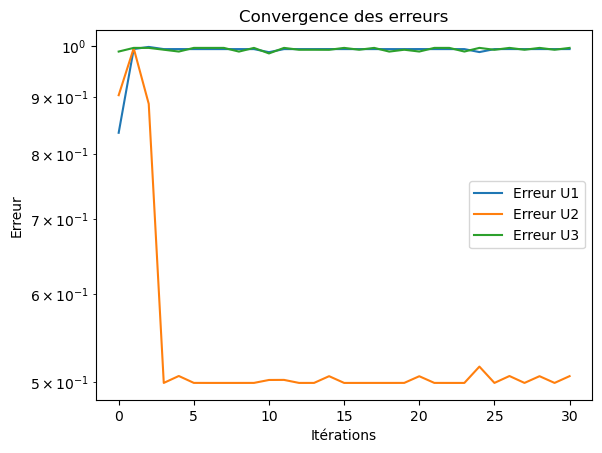

In [105]:
U1,U2,U3,G,erreurU1,erreurU2,erreurU3=Optimization(T, U1, U2, U3, G, max_iter,maxtime,tol)
print_results(erreurU1,erreurU2,erreurU3)